<center>
<img src="https://drive.google.com/uc?id=1riUbE9EWdQLmxcPIwrjkua85dzYbvGwC" alt="banner_fen_ajedrez">
</center>

# <center> **Generador FEN de Ajedrez** </center>

El sistema de notación Forsyth-Edwards es un tipo de notación utilizado en ajedrez. Propuesto en 1883, a diferencia de los sistemas de notación para jugadas y partidas, este sistema se utiliza para anotar una posición.

Las normas básicas del sistema Forsyth-Edwards son:

1. El tablero se lee de izquierda a derecha y de arriba abajo, empezando por la casilla a8. <br>
2. Las piezas blancas se nombran por su inicial en mayúsculas, y las piezas negras se nombran por su inicial en minúsculas. <br>
3. La posición se indica a partir de la primera fila de las negras, escribiendo cada elemento de izquierda a derecha e incluyendo el número de casillas vacías <br>
4. Cada fila se separa de las demás mediante una barra (/) <br>


<center>t1ar3t-p2pApCp-c4c2-1p1CP2P-6P1-3P4-P1P1R3-d5a1</center>

<center><img src="http://www.ajedrezdeataque.com/10%20Miscelanea/FEN/Tablero.jpg" alt=""></center>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from random import shuffle
from skimage.util.shape import view_as_blocks
from skimage import io, transform
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

In [ ]:
#Cantidad de imagenes en carpeta train
data_train = os.listdir("drive/MyDrive/dataset/train")
print(len(data_train))

39795


In [ ]:
#Cantidad de imagenes en carpeta test
data_test =  len(os.listdir("drive/MyDrive/dataset/test"))
print(data_test)

20000


In [ ]:
#Imagenes para trabajar
train_size = 500
test_size = 125


train = glob.glob("drive/MyDrive/dataset/train/*.jpeg")
test = glob.glob("drive/MyDrive/dataset/test/*.jpeg")

shuffle(train)
shuffle(test)

train = train[:train_size]
test = test[:test_size]


In [ ]:
#Obtener el FEN de cada imagen
def fen_img(filename):
  base = os.path.basename(filename)
  return os.path.splitext(base)[0]

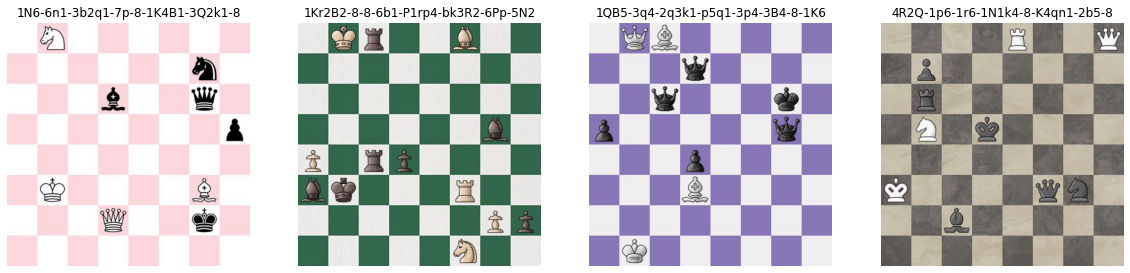

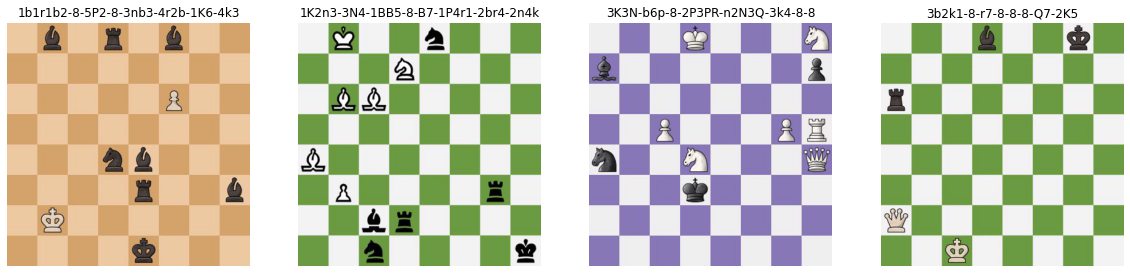

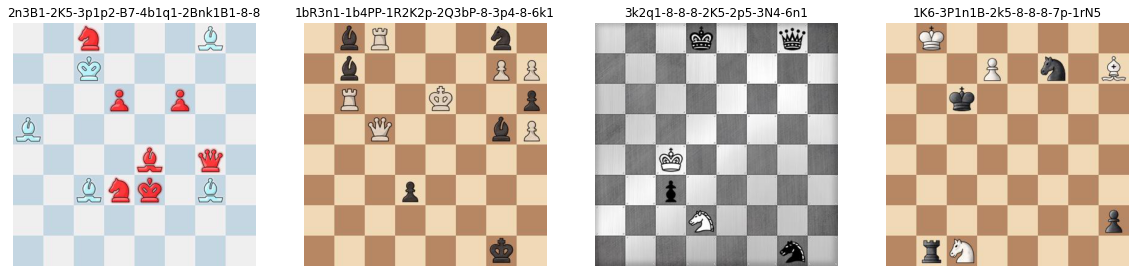

In [ ]:
for j in range(3):

  f, ax = plt.subplots(1,4, figsize=(20, 20))
  for i in range(0,4):
    ax[i].set_title(fen_img(train[i+j*4]))
    ax[i].imshow(mpimg.imread(train[i+j*4]))
    ax[i].axis('off')
    
    

In [ ]:
#Posibles piezas en casilla
pieces = 'prbnkqPRBNKQ'

#Funcion para transformar FEN en un array de numeros
def transform_fen(fen):
  output = np.empty((0, 1))
  fen = fen.replace('-','')
  for i in fen:
    if i in '12345678':
      output = np.append(
              output, np.tile('12',(int(i),1)), axis=0)
    else:
      output = np.append(output, np.tile(str(pieces.index(i)), (1,1)), axis=0)
  return np.int64(output)

#Funcion para obtener FEN apartir de matriz numerica
def onehot_a_fen(one_hot):
    output = ''
    for j in range(8):
        for i in range(8):
            if(one_hot[j][i] == 12):
                output += ' '
            else:
                output += pieces[one_hot[j][i]]
        if(j != 7):
            output += '-'

    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))

    return output

In [ ]:
#Funcion para redimensionar imagenes y dividirlas de bloques
def process_image(img):
    img_size = 200
    square_size = int(img_size/8)
    img_read = io.imread(img)
    img_read = transform.resize(
      img_read, (img_size, img_size), mode='constant')
    blocks = view_as_blocks(img_read, block_shape=(square_size, square_size, 3))
    blocks = blocks.squeeze(axis=2)
    return blocks.reshape(64, square_size, square_size, 3)

In [ ]:
def plot_process_image(blocks):
  plt.figure(figsize=(5,5), dpi=100) 
  for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(blocks[i])
    plt.xticks(())
    plt.yticks(())
    

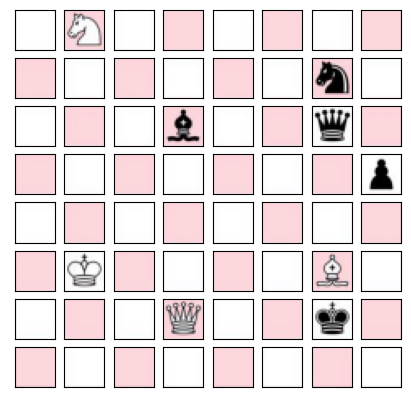

In [ ]:
blocks = process_image(train[0])
plot_process_image(blocks)

In [ ]:
def x_gen(images):
  x = []
  for i, img in enumerate(images):
    x.append(process_image(img))
  x = np.array(x).reshape(-1,25*25*3)
  return x
def y_gen(images):
  y= []
  for i, img in enumerate(images):
    y.append(transform_fen(fen_img(img)))
  y=np.array(y).reshape(-1)
  return y


## DecisionTreeClassifier

In [ ]:
#Definir profundidades para el estimador
depths = range(10,60,10)
scores_dt = []
predictions_dt = []

#Entrenamiento del estimador
for i, depth in enumerate(depths):
  dt = DecisionTreeClassifier(max_depth=depth)
  dt.fit(x_gen(train), y_gen(train))
  predictions_dt.append(dt.predict(x_gen(test)).reshape(-1,8,8))
  pre_f_dt = np.array([onehot_a_fen(j) for j in predictions_dt[i]])
  test_f_dt = np.array([fen_img(j) for j in test])
  scores_dt.append((pre_f_dt == test_f_dt).astype(float).mean())

Text(0.5, 1.0, 'DecisionTreeClassifier')

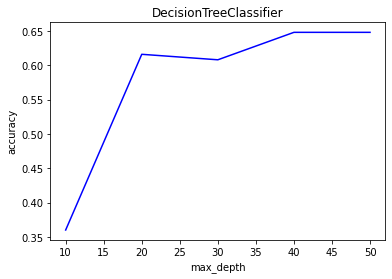

In [ ]:
#@title **Accuracy!**
plt.plot(range(10,60,10), scores_dt, color="blue")
plt.xlabel("max_depth");plt.ylabel("accuracy")
plt.title("DecisionTreeClassifier")

In [ ]:
#Funcion para graficar imagenes de test con label determinado por el estimador
def estimated_fen(image, i):
  plt.imshow(mpimg.imread(image))
  plt.axis('off')
  plt.title(pre_f_dt[i])
  plt.show()

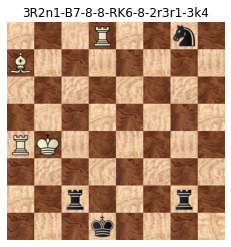

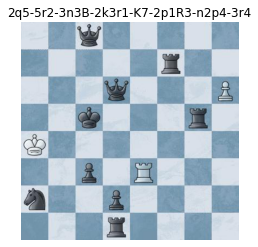

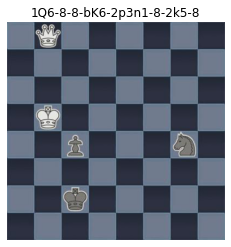

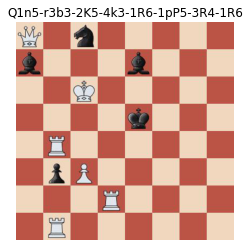

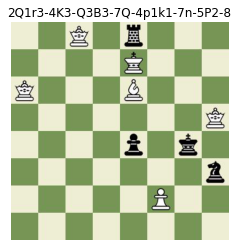

In [ ]:
for i in range(5):
  estimated_fen(test[i], i)

## SVC

In [ ]:
#Definicion de kernels a utlizar
kernels = ['linear', 'poly', 'rbf']
scores_svc = []
predictions_svc = []

#Entrenamiento de SVC
for i, kernel in enumerate(kernels):
  sv = SVC(kernel=kernel)
  sv.fit(x_gen(train), y_gen(train))
  predictions_svc.append(sv.predict(x_gen(test)).reshape(-1,8,8))
  pre_f_sv = np.array([onehot_a_fen(j) for j in predictions_svc[i]])
  test_f_sv = np.array([fen_img(j) for j in test])
  scores_svc.append((pre_f_sv == test_f_sv).astype(float).mean())

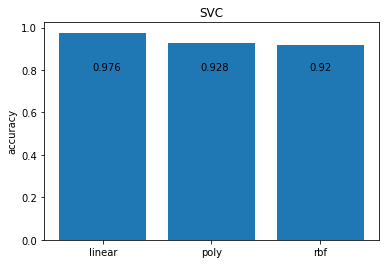

In [ ]:
#@title **Accuracy!**
fig, ax = plt.subplots()
ax.set_ylabel('accuracy')
ax.set_title('SVC')
ax.bar(kernels, scores_svc)
ax.text(-0.1, 0.8, str(scores_svc[0]))
ax.text(0.9, 0.8, str(scores_svc[1]))
ax.text(1.9, 0.8, str(scores_svc[2]))
plt.show()


In [ ]:
for i in range(5):
  print("FEN estimated: "+pre_f_sv[i])
  print("FEN Test:      " + test_f_sv[i])
  print("")

FEN estimated: 3R2n1-B7-8-8-RK6-8-2r3r1-3k4
FEN Test:      3R2n1-B7-8-8-RK6-8-2r3r1-3k4

FEN estimated: 2q5-5r2-3q3P-2k3r1-K7-2p1R3-n2p4-3r4
FEN Test:      2q5-5r2-3q3P-2k3r1-K7-2p1R3-n2p4-3r4

FEN estimated: 1Q6-8-8-1K6-6n1-8-8-8
FEN Test:      1Q6-8-8-1K6-2p3n1-8-2k5-8

FEN estimated: Q1n5-b3b3-2K5-4k3-1R6-1pP5-3R4-1R6
FEN Test:      Q1n5-b3b3-2K5-4k3-1R6-1pP5-3R4-1R6

FEN estimated: 2Q1r3-4K3-Q3B3-7Q-4p1k1-7n-5P2-8
FEN Test:      2Q1r3-4K3-Q3B3-7Q-4p1k1-7n-5P2-8



##RandomForestClassifier

In [ ]:
#Definicion de valores para n_estimators
n_estimators = range(10,50,10)
scores_rf = []
predictions_rf = []

#Entrenamiento de estimador
for i, n_estim in enumerate(n_estimators):
  rf = RandomForestClassifier(n_estimators=n_estim)
  rf.fit(x_gen(train), y_gen(train))
  predictions_rf.append(rf.predict(x_gen(test)).reshape(-1,8,8))
  pre_f_rf = np.array([onehot_a_fen(j) for j in predictions_rf[i]])
  test_f_rf = np.array([fen_img(i) for i in test])
  scores_rf.append((pre_f_rf == test_f_rf).astype(float).mean())

Text(0.5, 1.0, 'RandomForestClassifier')

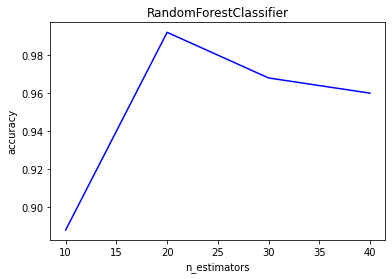

In [ ]:
#@title **Accuracy!**
plt.plot(range(10,50,10), scores_rf, color="blue")
plt.xlabel("n_estimators");plt.ylabel("accuracy")
plt.title("RandomForestClassifier")

In [ ]:
def estimated_fen(image, i):
  plt.imshow(mpimg.imread(image))
  plt.axis('off')
  plt.title(pre_f_rf[i])
  plt.show()

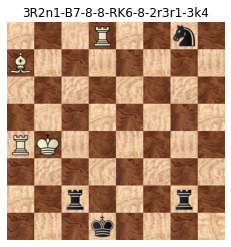

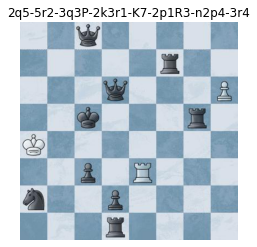

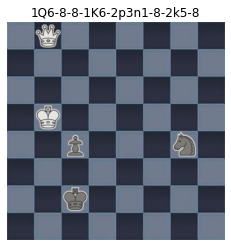

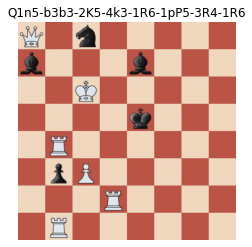

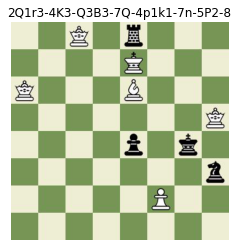

In [ ]:
for i in range(5):
  estimated_fen(test[i], i)

##CNN Convolutional Neural Network

In [ ]:
#Definicion de modelo red neuronal convolucional 
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(25, 25, 3)))
model.add(Activation('relu'))
model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(13))
model.add(Activation('softmax'))
model.compile(
  loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 23, 23, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 19, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 19, 19, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 23104)             0

In [ ]:
#Generador de datos X y labels Y para el modelo
def train_gen(images):
    for i, img in enumerate(images):
        y_tr = transform_fen(fen_img(img))
        y = tf.keras.utils.to_categorical(y_tr, num_classes=13).reshape(-1,13)
        x = process_image(img)
        yield x, y

def pred_gen(images):
    for i, img in enumerate(images):
        yield process_image(img)

In [ ]:
def test_gen(images):
    x = []
    for i, img in enumerate(images):
        x.append(process_image(img))
    x = np.array(x).reshape(-1,25,25,3)
    return x
def test_y_gen(images):
  y_t = []
  for i, img in enumerate(images):
      y_t.append(transform_fen(fen_img(img)))
      y = tf.keras.utils.to_categorical(y_t, num_classes=13).reshape(-1,13)
  return y

Epoch 1/10
50/50 [==============================] - 9s 41ms/step - loss: 1.1595 - accuracy: 0.7504 - val_loss: 0.4096 - val_accuracy: 0.9185
Epoch 2/10
50/50 [==============================] - 2s 33ms/step - loss: 0.3681 - accuracy: 0.9075 - val_loss: 0.1716 - val_accuracy: 0.9520
Epoch 3/10
50/50 [==============================] - 2s 34ms/step - loss: 0.1618 - accuracy: 0.9576 - val_loss: 0.1116 - val_accuracy: 0.9680
Epoch 4/10
50/50 [==============================] - 2s 35ms/step - loss: 0.1834 - accuracy: 0.9554 - val_loss: 0.0846 - val_accuracy: 0.9747
Epoch 5/10
50/50 [==============================] - 2s 34ms/step - loss: 0.0845 - accuracy: 0.9738 - val_loss: 0.0768 - val_accuracy: 0.9746
Epoch 6/10
50/50 [==============================] - 2s 35ms/step - loss: 0.0867 - accuracy: 0.9743 - val_loss: 0.0597 - val_accuracy: 0.9830
Epoch 7/10
50/50 [==============================] - 2s 36ms/step - loss: 0.0722 - accuracy: 0.9811 - val_loss: 0.0592 - val_accuracy: 0.9831
Epoch 8/10
50

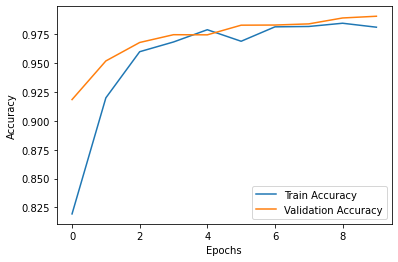

In [ ]:
#Entrenamiento del modelo convolucional
md = model.fit(train_gen(train), batch_size=64, epochs=10, steps_per_epoch=train_size/10, validation_data=(test_gen(test),test_y_gen(test)))
plt.plot(md.history['accuracy'], label='Train Accuracy')
plt.plot(md.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
#Guarda las predicciones del modelo convolucional
predictions = model.predict(pred_gen(test), batch_size=64).argmax(axis=1).reshape(-1, 8, 8)

In [ ]:
pre_f = np.array([onehot_a_fen(i) for i in predictions])
test_f = np.array([fen_img(i) for i in test])

final=(pre_f == test_f).astype(float).mean()

print("Final Accuracy: {:1.4f}%".format(final))

Final Accuracy: 0.6960%


In [ ]:
def estimated_fen(image, i):
  plt.imshow(mpimg.imread(image))
  plt.axis('off')
  plt.title(pre_f[i])
  plt.show()

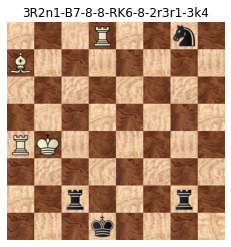

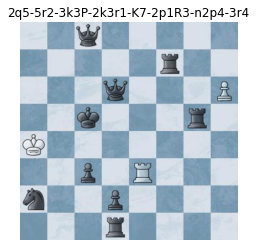

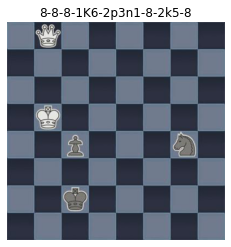

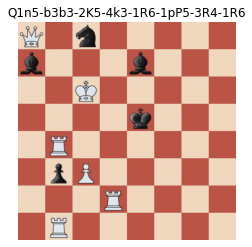

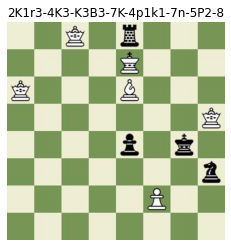

In [ ]:
for i in range(5):
  estimated_fen(test[i], i)